# expiMap

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 05.01.2023
- **Date of Last Modification:** 05.01.2023

The workflow of this notebook follows the tutorial from https://scarches.readthedocs.io/en/latest/expimap_surgery_pipeline_basic.html.

## 1. Setup

### 1.1 Import Libraries

In [1]:
from datetime import datetime

import gdown
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scarches as sca

 captum (see https://github.com/pytorch/captum).
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/home/cartalop/anaconda3/envs/expimap/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/cartalop/anaconda3/envs/expimap/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


### 1.2 Define Parameters

In [2]:
dataset = "squidpy_seqfish_mouse_organogenesis"
cell_type_key = "celltype_mapped_refined"
n_neighbors = 4
leiden_resolution = 0.3
random_seed = 0

### 1.3 Run Notebook Setup

In [3]:
sc.set_figure_params(figsize=(6, 6))

In [4]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and folder_pathectories

In [15]:
data_folder_path = "../datasets/srt_data/gold/"
figure_folder_path = f"../figures/{dataset}/benchmarking/"

## 2. Data

In [6]:
# Load Data
adata = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")
adata.layers["counts"] = adata.layers["counts"].tocsr()
adata.obs["sample"] = "sample_1"

## 3. expiMap Model

In [7]:
url = 'https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c'
output = 'reactome.gmt'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c
To: /home/cartalop/sebastianbirk/autotalker-reproducibility/expimap/reactome.gmt
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 331k/331k [00:00<00:00, 2.50MB/s]


'reactome.gmt'

In [8]:
sca.utils.add_annotations(adata, 'reactome.gmt', min_genes=12, clean=True)

In [9]:
# Remove all genes which are not present in the Reactome annotations
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [10]:
# Filter out all annotations (terms) with less than 12 genes
select_terms = adata.varm['I'].sum(0)>12
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [11]:
intr_cvae = sca.models.EXPIMAP(adata=adata,
                               condition_key="sample",
                               hidden_layer_sizes=[256, 256, 256],
                               recon_loss='nb')


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 65 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 6
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  6 0 0 1 65
	with hard mask.
Last Decoder layer: softmax


In [12]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400,
    alpha_epoch_anneal=100,
    alpha=0.7,
    alpha_kl=0.5,
    weight_decay=0.,
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    monitor_only_val=False,
    seed=2020,
)

Init the group lasso proximal operator for the main terms.
 |█████---------------| 27.5%  - epoch_loss: 52.8177325952 - epoch_recon_loss: 50.8428086886 - epoch_kl_loss: 3.9498474894 - val_loss: 52.4412195683 - val_recon_loss: 50.3935999870 - val_kl_loss: 4.09523911770
ADJUSTED LR
 |██████--------------| 30.8%  - epoch_loss: 52.8523118235 - epoch_recon_loss: 50.8730194203 - epoch_kl_loss: 3.9585845401 - val_loss: 52.0592660904 - val_recon_loss: 50.1030464172 - val_kl_loss: 3.9124400467
ADJUSTED LR
 |██████--------------| 34.8%  - epoch_loss: 52.6693166190 - epoch_recon_loss: 50.6909814821 - epoch_kl_loss: 3.9566703034 - val_loss: 52.6169695854 - val_recon_loss: 50.6674904823 - val_kl_loss: 3.8989581019
ADJUSTED LR
 |███████-------------| 38.0%  - epoch_loss: 53.0623439872 - epoch_recon_loss: 51.0749635348 - epoch_kl_loss: 3.9747610701 - val_loss: 52.0923249722 - val_recon_loss: 50.1378610134 - val_kl_loss: 3.9089283198
ADJUSTED LR
 |████████------------| 41.2%  - epoch_loss: 52.87487116

In [13]:
adata.obsm["X_cvae"] = intr_cvae.get_latent(mean=False, only_active=True)

/home/cartalop/anaconda3/envs/expimap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


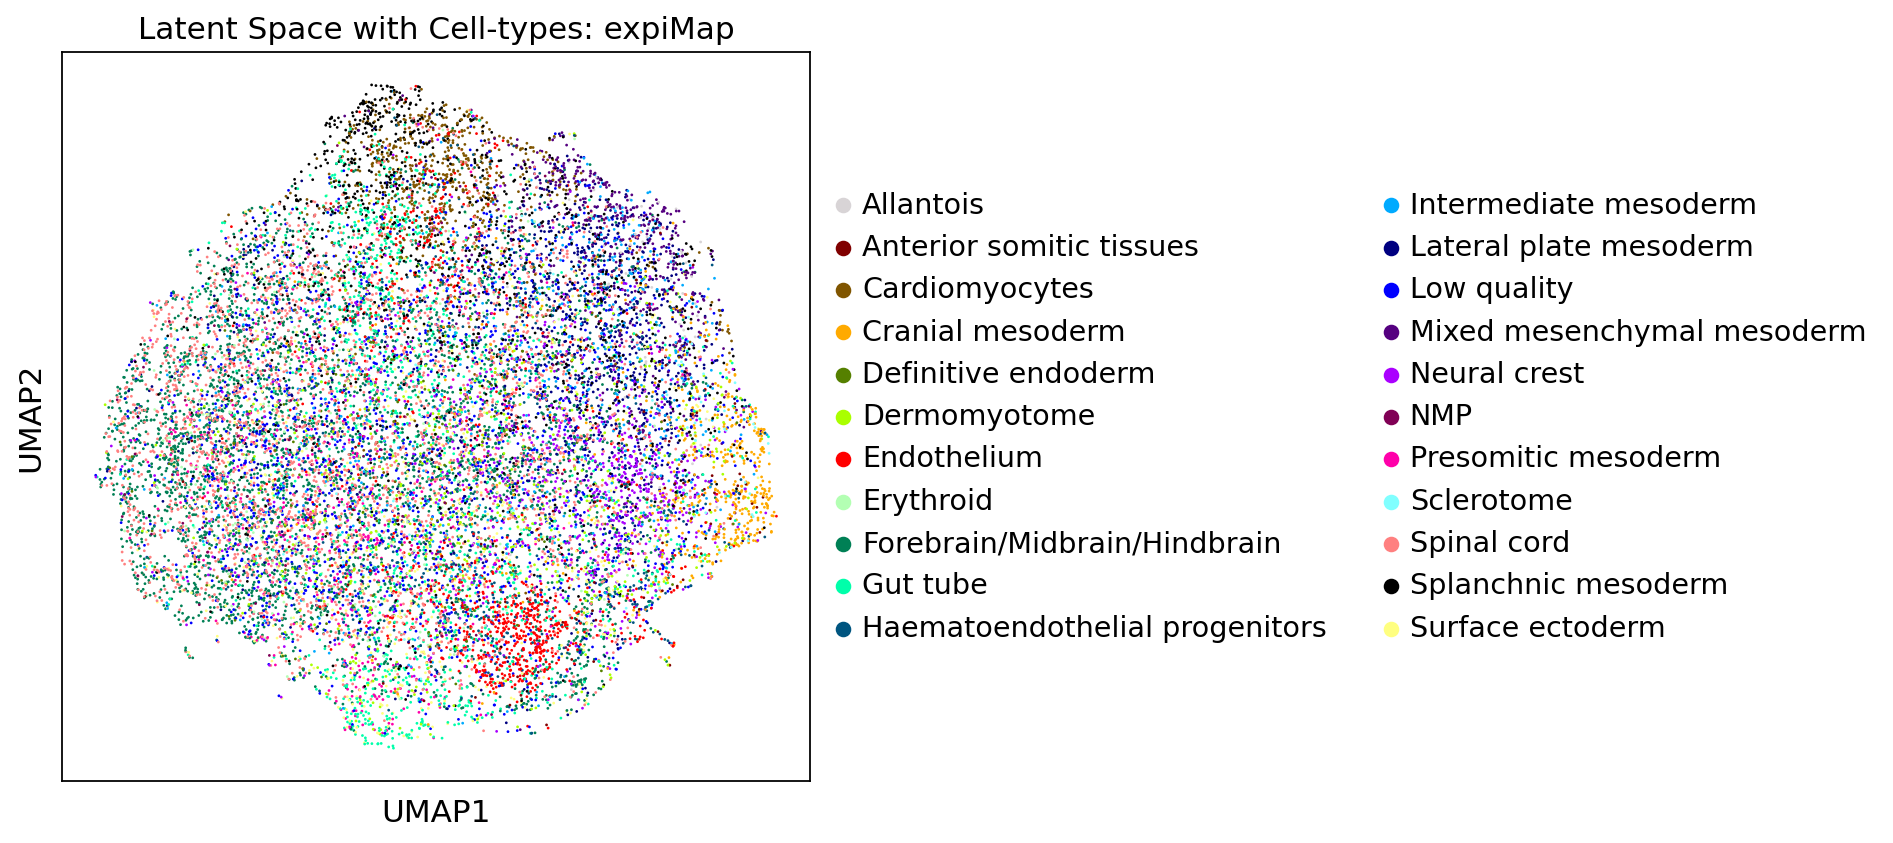

In [16]:
# Use expiMap latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_cvae", n_neighbors=n_neighbors)
sc.tl.umap(adata, min_dist=0.3)

fig = sc.pl.umap(adata,
                 color=[cell_type_key],
                 title="Latent Space with Cell-types: expiMap",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_expimap_cell_types_{current_timestamp}.png",
            bbox_inches="tight")

In [18]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=adata,
             resolution=leiden_resolution,
             random_state=random_seed,
             key_added=f"latent_expimap_leiden_{str(leiden_resolution)}")

/home/cartalop/anaconda3/envs/expimap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


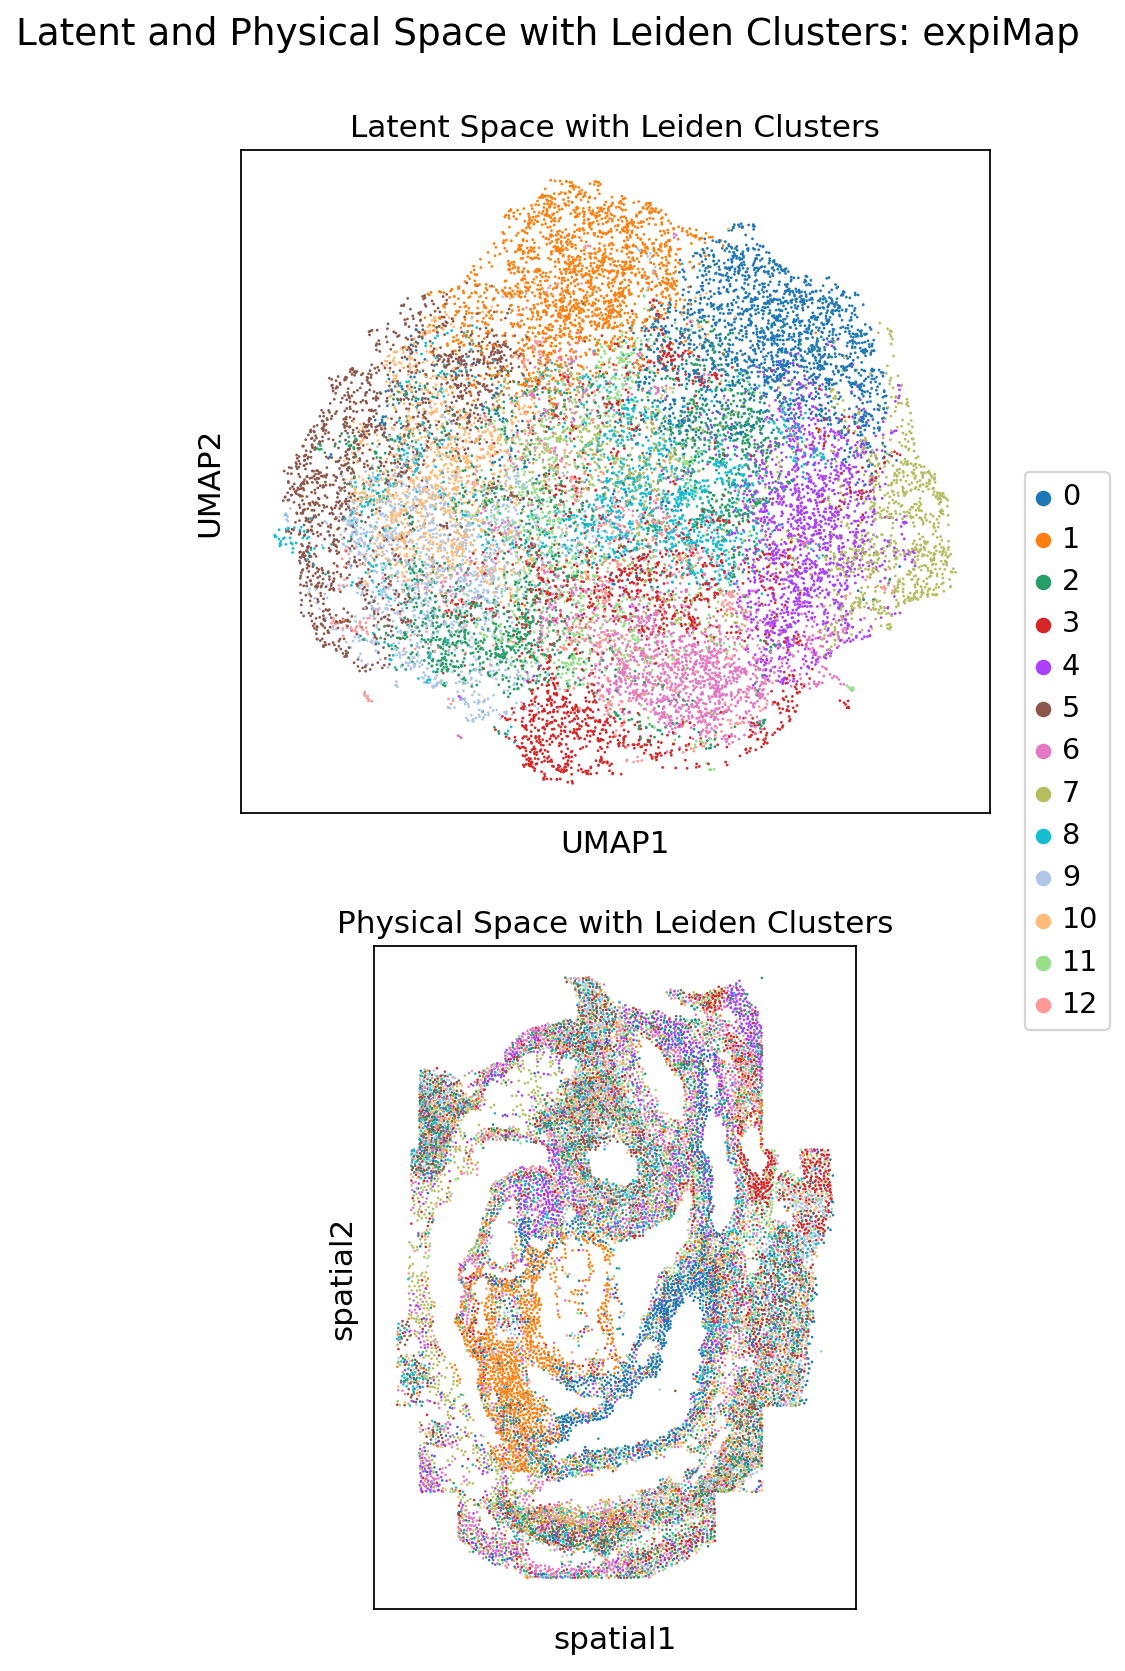

In [20]:
# Create subplot of latent Leiden cluster annotations in physical and latent space
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))
title = fig.suptitle(t="Latent and Physical Space with Leiden Clusters: expiMap")
sc.pl.umap(adata=adata,
           color=[f"latent_expimap_leiden_{str(leiden_resolution)}"],
           title=f"Latent Space with Leiden Clusters",
           ax=axs[0],
           show=False)
sc.pl.spatial(adata=adata,
              color=[f"latent_expimap_leiden_{str(leiden_resolution)}"],
              spot_size=0.03,
              title=f"Physical Space with Leiden Clusters",
              ax=axs[1],
              show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.1, 0.75))
axs[0].get_legend().remove()
axs[1].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0, hspace=0.2)
fig.savefig(f"{figure_folder_path}/latent_physical_comparison_expimap_leiden_{current_timestamp}.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()